# Building a CNN Chest Xray Pneumonia Classifier using Transfer Learning

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing,
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import cv2
from tensorflow.keras import Model
import os
import glob
import seaborn as sns

In [2]:
#printing the number of classes with class name
ds = '../input/chest-xray-pneumonia/chest_xray/train'
print(len(os.listdir(ds)),'Classes')
uniq_labels = sorted(os.listdir(ds))
print(uniq_labels)

2 Classes
['NORMAL', 'PNEUMONIA']


In [14]:
normal = glob.glob(ds+"/NORMAL/*.jpeg")
pneumonia = glob.glob(ds+"/PNEUMONIA/*.jpeg")

<AxesSubplot:>

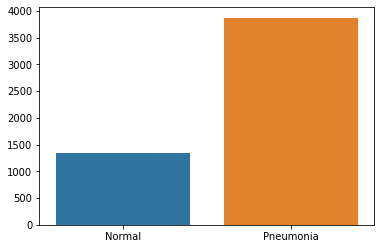

In [16]:
sns.barplot(x=["Normal","Pneumonia"],y=[len(normal),len(pneumonia)])

# Transfer Learning: Importing the Inception model

In [43]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Creating an instance of the inception model from the imagenet weights
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                               include_top = False,
                               weights='imagenet')

# Making all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

# Making the mixed7 layer as our last layer 

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


# Adding our Output layer to the Pre-defined Model

In [5]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)                  
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Creating ImageDatagenerator with Data-Augmentation

In [6]:
TRAINING_DIR = "../input/chest-xray-pneumonia/chest_xray/train"
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest'
                    #preprocessing_function=myFunc
)

VALIDATION_DIR = "../input/chest-xray-pneumonia/chest_xray/val"
val_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest'
                   # preprocessing_function=myFunc
)

train_generator = train_datagen.flow_from_directory(
                    TRAINING_DIR,
                    batch_size=32,
                    class_mode='binary',
                    target_size=(150, 150)
)

validation_generator = val_datagen.flow_from_directory(
                    VALIDATION_DIR,
                    batch_size=32,
                    class_mode='binary',
                    target_size=(150, 150))


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.0001)

# Training the Model

In [8]:
history = model.fit_generator(train_generator,
                    epochs=10,
                    verbose = 1,
                    validation_data = validation_generator,
                    callbacks = [learning_rate_reduction])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 228s 1s/step - loss: 0.4947 - acc: 0.8361 - val_loss: 0.2376 - val_acc: 0.8125
Epoch 2/10
163/163 [==============================] - 188s 1s/step - loss: 0.1924 - acc: 0.9231 - val_loss: 0.4302 - val_acc: 0.7500
Epoch 3/10
163/163 [==============================] - 187s 1s/step - loss: 0.1726 - acc: 0.9327 - val_loss: 0.7421 - val_acc: 0.7500
Epoch 4/10
163/163 [==============================] - 189s 1s/step - loss: 0.1676 - acc: 0.9446 - val_loss: 1.6893 - val_acc: 0.5625
Epoch 5/10
163/163 [==============================] - 189s 1s/step - loss: 0.1360 - acc: 0.9483 - val_loss: 0.9111 - val_acc: 0.7500
Epoch 6/10
163/163 [==============================] - 187s 1s/step - loss: 0.1285 - acc: 0.9506 - val_loss: 1.3080 - val_acc: 0.5000
Epoch 7/10
163/163 [==============================] - 187s 1s/step - loss: 0.1409 - acc: 0.9486 - val_loss: 1.6009 - val_acc: 0.5625
Epoch 8/10
163/163 [==============================] - 187s 1s/step - 

# Plotting Accuracy and Loss Curves

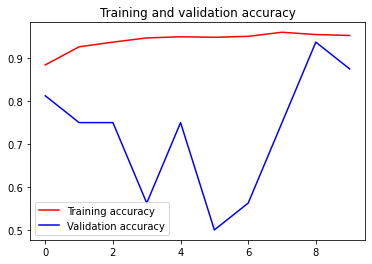

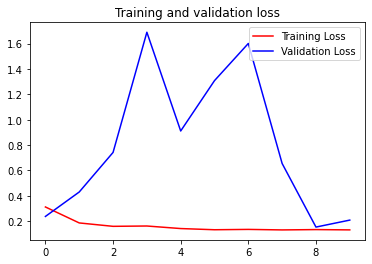

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Defining Test Image Generator

In [10]:
TEST_DIR = "../input/chest-xray-pneumonia/chest_xray/test/"
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(TEST_DIR,
                                          batch_size=32,
                                          target_size=(150,150),
                                          class_mode="binary")

Found 624 images belonging to 2 classes.


# Model Evaluation

In [21]:
result = model.evaluate(test)

20/20 [==============================] - 15s 713ms/step - loss: 0.2736 - acc: 0.9135


# We got 91.35% Test Accuracy. That's good! Without tuning our hyperparameters.

# Ploting Images

In [24]:
images, labels = next(test)

In [40]:
class_names = train_generator.class_indices
class_names = list(class_names.keys())

In [41]:
def plotImages(image, label):
    plt.figure(figsize=[22,14])
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(image[i])
        plt.title(f"Class : {class_names[np.argmax(label[i])]}")
        plt.axis("off")
    plt.show()

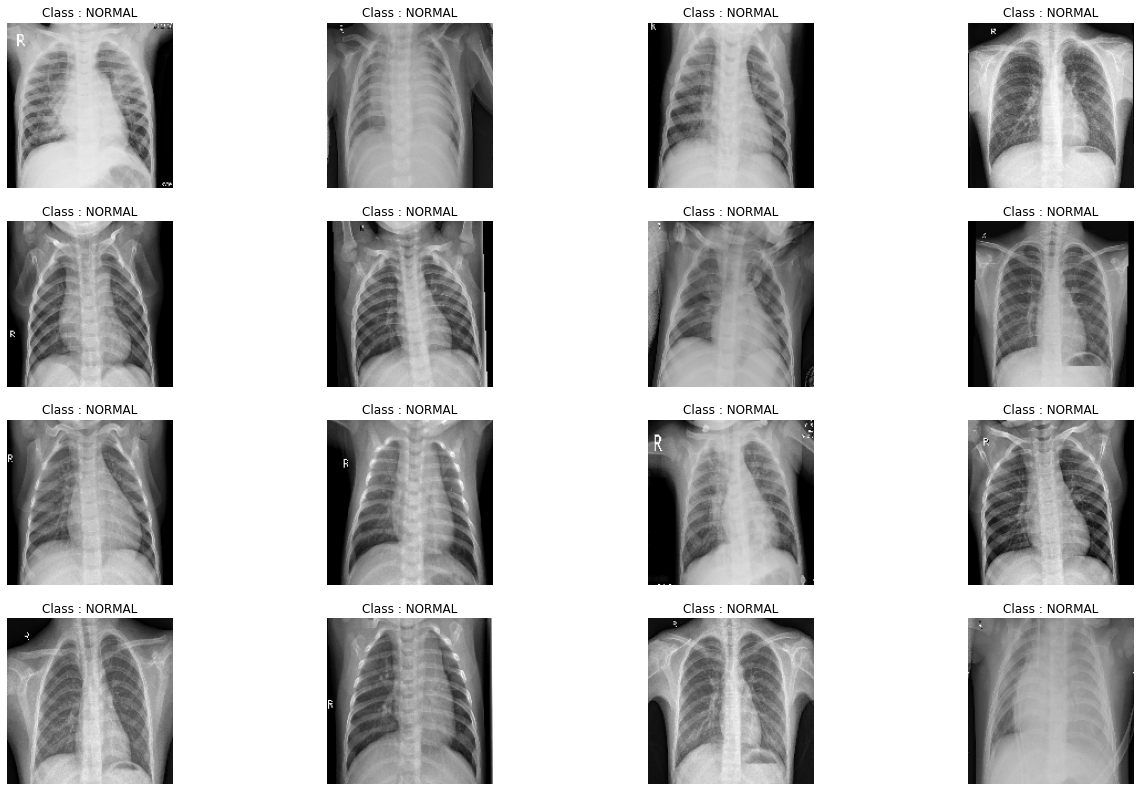

In [42]:
plotImages(images,labels)